


<a name="Libraries"></a>
## This notebook is team 828's Notebook for the OpenGeoAI 2023 Hackathon

### The goal is to predict, from Sentinel-2 multispectral images, whether a piece of land contains Olive trees or not.

### We achieved a 0.8 accuracy and were ranked 6/25 in the competition


In [ ]:
from IPython.display import clear_output
# Install dew required libraries
!pip install pyunpack
!pip install patool
!pip install rasterio
clear_output()

In [ ]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import rasterio
import cv2

<a name="Data"></a>

---


## ATTENTION! Make sure to fix the google drive paths of the files !!!!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load files (fix drive path)

df_train = gpd.read_file("/content/drive/MyDrive/SOUSSA/files/train/train.shp")   #train.shp file
df_test = gpd.read_file("/content/drive/MyDrive/SOUSSA/files/test/test.shp")      #test.shp file
samplesubmission = pd.read_csv("/content/drive/MyDrive/SOUSSA/files/SampleSubmission.csv")

# Preview train dataset
df_train.head()

,ID,target,geometry
0,i8KjaioEry,Oliver,"POLYGON ((594953.280 3941992.379, 595056.013 3..."
1,r4R40t2viH,Not_Oliver,"POLYGON ((590022.913 3938388.281, 590082.417 3..."
2,DO23GvlVNP,Oliver,"POLYGON ((590202.661 3938021.080, 590230.442 3..."
3,QREaKEZGg9,Not_Oliver,"POLYGON ((594379.858 3938850.027, 594367.825 3..."
4,S0I7TjiGk7,Oliver,"POLYGON ((592795.839 3936363.014, 592674.645 3..."


In [ ]:
# Preview sample submission file
samplesubmission

,ID,target
0,mYiCy5N2Lu,NaN
1,jj71Q5YNAP,NaN
2,ULmJvrpODn,NaN
3,h0kkdA6DZo,NaN
4,1IdjR4SK5P,NaN
...,...,...
496,ZyAhlVpJ3I,NaN
497,MfDjjCAY5C,NaN
498,Krtf3uPU4j,NaN
499,vTVw7BGhg5,NaN


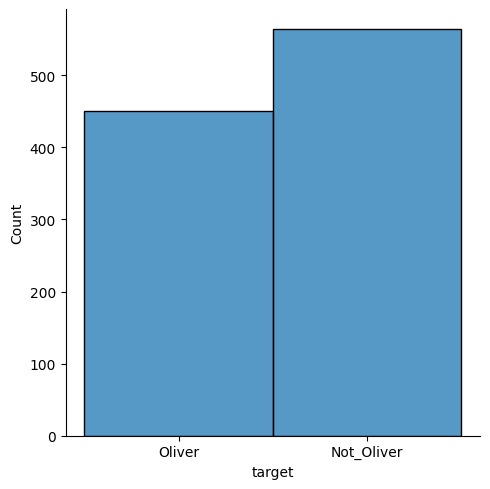

In [ ]:
sns.displot(df_train, x="target")

## To visualize the images

In [ ]:
# Load the images paths
path_satellite__data= "/content/drive/MyDrive/SOUSSA/GeoAIHack2023/"  #fix path
images_list= os.listdir(path_satellite__data)

In [ ]:
# Store all 24 images in an array

images=[]
for i in range(24):
  image_path = f"{path_satellite__data}{images_list[i]}"
  with rasterio.open(image_path) as src:
    # Read the image as an array
    image = src.read()
    images.append(image)
len(images)

24

In [ ]:
# Open 1 timestamp example image
image_path = f"{path_satellite__data}{images_list[23]}"
with rasterio.open(image_path) as src:
    # Get the image metadata
    metadata = src.meta
    # Read the image as an array
    image = src.read()

In [ ]:
image.shape

(10, 1969, 1663)

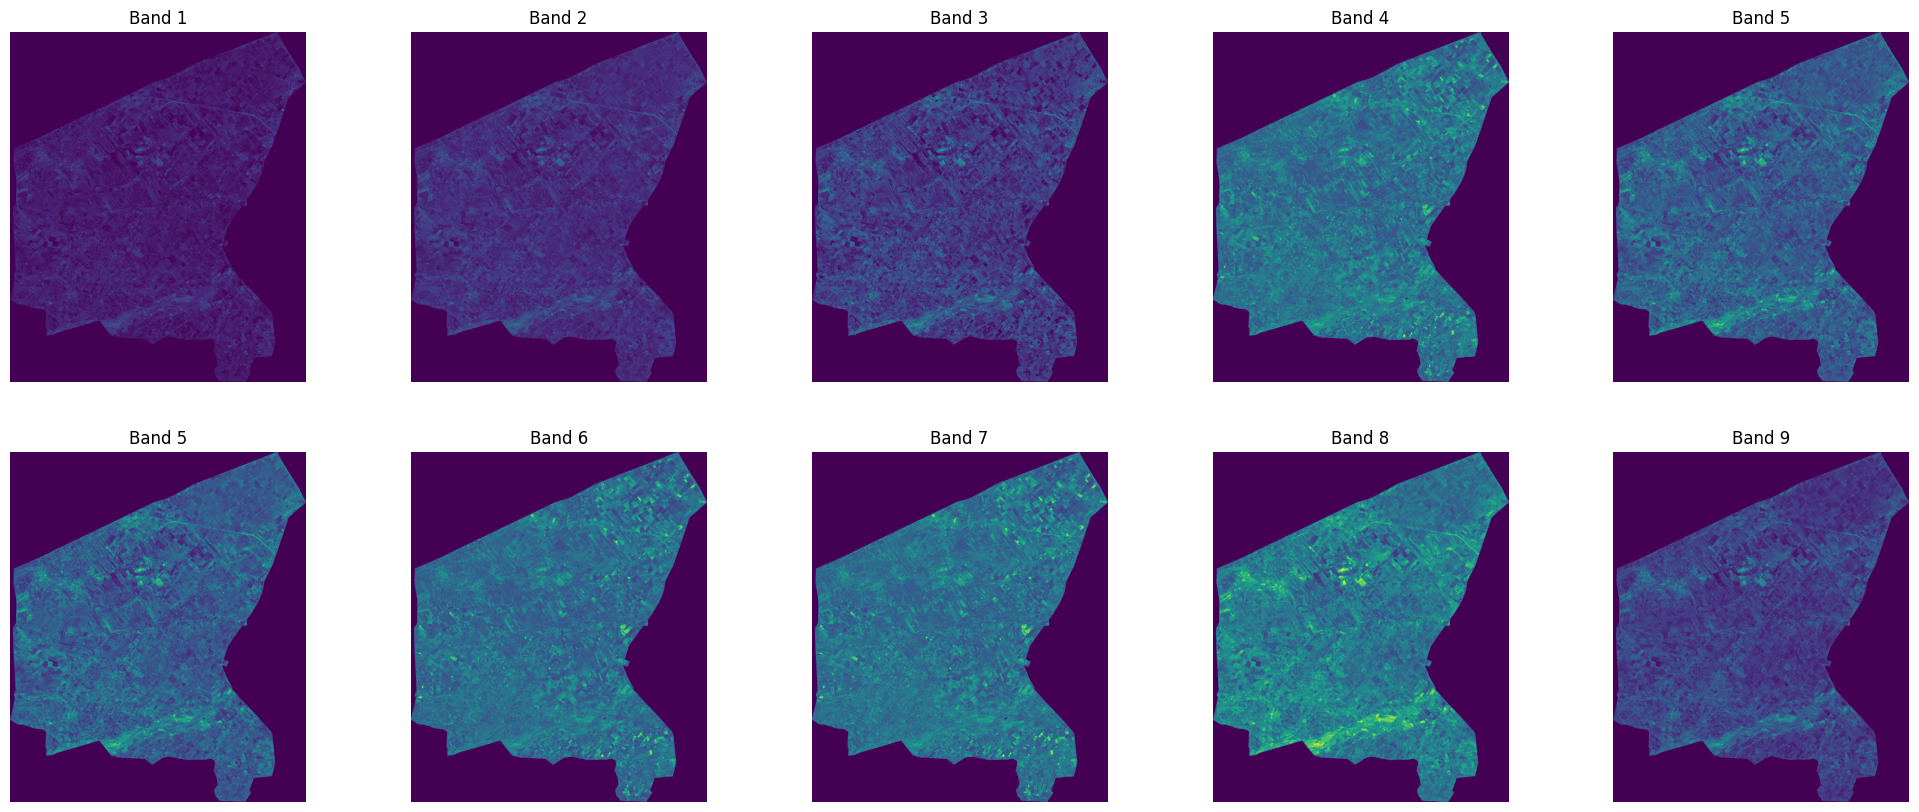

In [ ]:
# Plot the Spectral-Bands of the image
# The Sentinel-2 Spectral band includes "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"
fig, ax = plt.subplots(2, 5, figsize=(25, 10))

for i in range(2):
    for j in range(5):
        ax[i,j].imshow(image[i*4+j,:,:])
        ax[i,j].set_title("Band {}".format(i*4+j+1))
        ax[i,j].axis("off")

<a name="ML"></a>
## Data Preparation

### The Data is composed of 24 Sentinel-2 multispectral images of the same location taken at different times, each image is composed of 10 layers (one for each spectral band). We seek to exploit all the 24 images as well as all the 10 layers of each one. The data also offers geometrical masks to be able to separate the pieces of land in the location and make our prediction on each piece of land

### the cell below creates a big dataset that measures multiple statistical characteristics of the images of each piece of land in the area.

In [ ]:
from rasterio.features import geometry_mask
# Transform the field image data into statistical features (mean and std of each spectral Bands) and combine them into a dataframe

# Concatenate the training and testing dataframes into a single dataframe
df_all= pd.concat([df_train, df_test], ignore_index=True)

# Initialize an empty list to store the processed data
processed_data= []
surfaces = []
field = []
# Loop through each field in the concatenated dataframe
for index, row in df_all.iterrows():
    # Get the geometry of the field
    field_geometry = row['geometry']
    # Create a mask for the field
    field_mask = geometry_mask([field_geometry], out_shape=src.shape, transform=src.transform, invert=True)

    # Extract the image data for the field
    field_data = image[:, field_mask]
    field.append(field_data)

    surface = field_data.shape[1]
    surfaces.append(surface)
    # Compute the mean and standard deviation of each channel of the image data
    mean_values = np.mean(field_data, axis=1)
    std_values = np.std(field_data, axis=1)

    # Concatenate the mean and standard deviation values into a single feature vector
    features = np.concatenate([mean_values, std_values,])
    # Append the feature vector to the list of processed data
    processed_data.append(features)

# Convert the list of processed data into a pandas dataframe
processed_data_df= pd.DataFrame(processed_data, columns=[f"mean_channel_{i}" for i in range(0, 10)] + [f"std_channel_{i}" for i in range(0, 10)])
processed_data_df["surface"]=surfaces
processed_data_df["ID"]= df_all["ID"]

In [ ]:
from rasterio.features import geometry_mask
# Transform the field image data into statistical features (mean and std of each spectral Bands) and combine them into a dataframe
def flat(mean_values):
  l=[]
  for e in mean_values:
    for k in range(10):
      l.append(e[k])
  return l
# Concatenate the training and testing dataframes into a single dataframe
df_all= pd.concat([df_train, df_test], ignore_index=True)

# Initialize an empty list to store the processed data
processed_data_version2= []
# Loop through each field in the concatenated dataframe
for index, row in df_all.iterrows():
    mean_values=[]
    std_values=[]
    min_values=[]
    max_values=[]
    q25_values=[]
    q75_values=[]
    # Get the geometry of the field
    field_geometry = row['geometry']
    # Create a mask for the field
    field_mask = geometry_mask([field_geometry], out_shape=src.shape, transform=src.transform, invert=True)
    for image in images:
      # Extract the image data for the field
      field_data = image[:, field_mask]

      # Compute the statistics over the image
      image_mean_values = np.mean(field_data, axis=1)
      mean_values.append(image_mean_values)

      image_q25_values=np.percentile(field_data,25,axis=1)
      q25_values.append(image_q25_values)

      image_q75_values=np.percentile(field_data,78,axis=1)
      q75_values.append(image_q75_values)

      image_std_values =  np.std(field_data, axis=1)
      std_values.append(image_std_values)

      image_min_values =  np.min(field_data, axis=1)
      min_values.append(image_min_values)

      image_max_values =  np.max(field_data,axis=1)
      max_values.append(image_max_values)



    # Concatenate the statistics into a single feature vector
    features = np.concatenate([flat(mean_values),flat(q25_values),flat(q75_values),flat(std_values),flat(min_values),flat(max_values)])
    # Append the feature vector to the list of processed data
    processed_data_version2.append(features)

### Here we seek to calculate the gndvi (Green Normalized Difference Vegetation Index) of the area to help us make better predictions

In [ ]:
processed_data_version2 = pd.DataFrame(processed_data_version2, columns = [f"mean_{i}" for i in range(240)] + [f"q25_{i}" for i in range(240)] +[f"q75_{i}" for i in range(240)] +[f"std_{i}" for i in range(240)] +[f"min_{i}" for i in range(240)] +[f"max_{i}" for i in range(240)])


In [ ]:
processed_data_version2["gndvi"]= gndvi
processed_data_version2["surface"]= surfaces

In [ ]:
gndvi = (processed_data_df['mean_channel_6'] - processed_data_df['mean_channel_1'])/(processed_data_df['mean_channel_6'] + processed_data_df['mean_channel_1'])
processed_data_df["gndvi"]=gndvi

In [ ]:
processed_data_version2

,mean_0,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,...,max_232,max_233,max_234,max_235,max_236,max_237,max_238,max_239,gndvi,surface
0,861.576490,1293.840580,1566.771337,1952.204509,2598.980676,2821.995169,3064.943639,3380.581320,2685.074074,3008.260870,...,2332.0,2912.0,2528.0,3095.0,3440.0,3543.0,3014.0,3254.0,0.414813,621
1,915.640449,1401.791011,1783.734831,2151.584270,2639.952809,2820.024719,3031.339326,3572.258427,2850.986517,2972.184270,...,1876.0,2534.0,2095.0,2672.0,2908.0,3151.0,2373.0,2822.0,0.395377,445
2,1035.385965,1534.666667,1981.122807,2229.263158,2524.859649,2685.017544,2872.526316,3713.912281,3166.561404,2806.421053,...,1360.0,2111.0,1959.0,2335.0,2050.0,3298.0,2593.0,2441.0,0.369943,57
3,1257.777778,1655.333333,1981.555556,2034.444444,2568.666667,2792.000000,3030.000000,3062.000000,2513.888889,2898.888889,...,2230.0,2356.0,2013.0,2444.0,2858.0,2943.0,2216.0,2561.0,0.277787,9
4,568.127737,902.051095,1165.952555,1379.897810,1815.529197,2011.359489,2126.423358,2429.468978,1810.709854,2110.558394,...,1648.0,2420.0,1967.0,2575.0,2634.0,2697.0,1861.0,2750.0,0.431281,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,774.266667,1218.694737,1611.715789,1913.950877,2497.498246,2768.585965,3004.884211,3504.235088,3036.550877,2933.361404,...,2182.0,2335.0,2022.0,2602.0,3062.0,2996.0,2377.0,2728.0,0.419184,285
1512,485.754545,882.463636,726.336364,1341.718182,3118.336364,3600.754545,3826.745455,2316.027273,1397.118182,3660.172727,...,1476.0,2436.0,1848.0,2614.0,2930.0,2464.0,1683.0,2755.0,0.428837,110
1513,681.500000,1068.161290,1275.612903,1630.645161,2239.806452,2437.322581,2614.838710,2652.596774,1923.870968,2595.838710,...,1664.0,2758.0,1861.0,2983.0,3272.0,2529.0,1805.0,3028.0,0.503544,62
1514,295.246879,565.474341,446.324549,910.262136,2721.915395,3535.952843,3763.914008,1621.993065,883.350902,3680.345354,...,2160.0,2908.0,2107.0,3289.0,3618.0,2645.0,1953.0,3262.0,0.502571,721


In [ ]:
processed_data_version2['target']=df_train['target']

In [ ]:
processed_data_version2

,mean_0,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,...,max_233,max_234,max_235,max_236,max_237,max_238,max_239,gndvi,surface,target
0,861.576490,1293.840580,1566.771337,1952.204509,2598.980676,2821.995169,3064.943639,3380.581320,2685.074074,3008.260870,...,2912.0,2528.0,3095.0,3440.0,3543.0,3014.0,3254.0,0.414813,621,Oliver
1,915.640449,1401.791011,1783.734831,2151.584270,2639.952809,2820.024719,3031.339326,3572.258427,2850.986517,2972.184270,...,2534.0,2095.0,2672.0,2908.0,3151.0,2373.0,2822.0,0.395377,445,Not_Oliver
2,1035.385965,1534.666667,1981.122807,2229.263158,2524.859649,2685.017544,2872.526316,3713.912281,3166.561404,2806.421053,...,2111.0,1959.0,2335.0,2050.0,3298.0,2593.0,2441.0,0.369943,57,Oliver
3,1257.777778,1655.333333,1981.555556,2034.444444,2568.666667,2792.000000,3030.000000,3062.000000,2513.888889,2898.888889,...,2356.0,2013.0,2444.0,2858.0,2943.0,2216.0,2561.0,0.277787,9,Not_Oliver
4,568.127737,902.051095,1165.952555,1379.897810,1815.529197,2011.359489,2126.423358,2429.468978,1810.709854,2110.558394,...,2420.0,1967.0,2575.0,2634.0,2697.0,1861.0,2750.0,0.431281,548,Oliver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,774.266667,1218.694737,1611.715789,1913.950877,2497.498246,2768.585965,3004.884211,3504.235088,3036.550877,2933.361404,...,2335.0,2022.0,2602.0,3062.0,2996.0,2377.0,2728.0,0.419184,285,NaN
1512,485.754545,882.463636,726.336364,1341.718182,3118.336364,3600.754545,3826.745455,2316.027273,1397.118182,3660.172727,...,2436.0,1848.0,2614.0,2930.0,2464.0,1683.0,2755.0,0.428837,110,NaN
1513,681.500000,1068.161290,1275.612903,1630.645161,2239.806452,2437.322581,2614.838710,2652.596774,1923.870968,2595.838710,...,2758.0,1861.0,2983.0,3272.0,2529.0,1805.0,3028.0,0.503544,62,NaN
1514,295.246879,565.474341,446.324549,910.262136,2721.915395,3535.952843,3763.914008,1621.993065,883.350902,3680.345354,...,2908.0,2107.0,3289.0,3618.0,2645.0,1953.0,3262.0,0.502571,721,NaN


In [ ]:
# Retrive the train and test sets
processed_train_df= processed_data_version2.iloc[:len(df_train), :]
last_train = pd.concat([processed_train_df,df_train["target"]], axis=1)
processed_test_df= processed_data_df.iloc[len(df_train):, :]
processed_test_df.reset_index(drop=True, inplace=True)

last_train = pd.get_dummies(last_train, columns=['target'])
last_train = last_train.drop(columns=['target_Not_Oliver'])
last_train

,mean_channel_0,mean_channel_1,mean_channel_2,mean_channel_3,mean_channel_4,mean_channel_5,mean_channel_6,mean_channel_7,mean_channel_8,mean_channel_9,...,std_channel_4,std_channel_5,std_channel_6,std_channel_7,std_channel_8,std_channel_9,surface,ID,gndvi,target_Oliver
0,545.967794,949.418680,1171.668277,1965.560386,1483.394525,2144.547504,2295.420290,2505.692432,1867.565217,2313.434783,...,307.988603,328.806351,364.297730,254.303920,242.237007,308.691250,621,i8KjaioEry,0.414813,1
1,588.078652,1019.880899,1314.152809,2070.285393,1687.555056,2214.984270,2353.725843,2650.474157,1817.905618,2385.447191,...,103.132356,95.876617,98.067101,155.686612,163.322250,94.928998,445,r4R40t2viH,0.395377,0
2,485.859649,769.929825,1022.649123,1473.385965,1295.421053,1619.491228,1674.070175,2527.421053,1894.175439,1786.649123,...,232.246387,219.452279,130.063393,293.241709,241.122166,214.567823,57,DO23GvlVNP,0.369943,1
3,1006.666667,1470.666667,1790.666667,2227.555556,1898.888889,2373.222222,2602.000000,2717.222222,2067.333333,2478.888889,...,118.328586,81.358982,218.381928,172.625978,103.578204,72.182553,9,QREaKEZGg9,0.277787,0
4,461.153285,900.753650,1186.390511,1974.062044,1495.958029,2162.202555,2266.905109,2193.593066,1385.122263,2288.357664,...,137.361251,94.244678,99.254512,162.568942,130.760206,92.997252,548,S0I7TjiGk7,0.431281,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,399.469027,711.828909,846.530973,1783.197640,1204.286136,1990.814159,2128.023599,2273.781711,1677.604720,2196.681416,...,212.076747,220.607737,259.509952,235.528952,233.920208,223.428789,339,r0jIWPQYDm,0.498686,1
1011,442.731707,812.349593,1039.219512,1884.813008,1312.869919,2133.040650,2242.243902,2012.268293,1360.422764,2270.837398,...,257.097873,206.611469,247.709978,277.951890,218.741300,208.048125,123,5ugCvMqZx1,0.468113,1
1012,350.380952,708.523810,701.904762,2368.714286,1214.873016,2654.698413,2843.047619,1834.904762,1181.904762,2837.380952,...,260.108432,209.749104,347.502081,377.023670,361.891623,194.799566,63,Z6cOOBkGyH,0.601008,1
1013,496.344828,991.310345,971.862069,2639.241379,1653.896552,2852.517241,3048.689655,2144.655172,1461.275862,3003.517241,...,300.423993,227.693021,264.802477,298.419662,336.761032,213.014265,29,O3lLDVEDm4,0.509252,0


In [ ]:
last_train.corr()

<ipython-input-18-cde8b9a8c087>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  last_train.corr()


,mean_channel_0,mean_channel_1,mean_channel_2,mean_channel_3,mean_channel_4,mean_channel_5,mean_channel_6,mean_channel_7,mean_channel_8,mean_channel_9,...,std_channel_3,std_channel_4,std_channel_5,std_channel_6,std_channel_7,std_channel_8,std_channel_9,surface,gndvi,target_Oliver
mean_channel_0,1.000000,0.974142,0.967953,0.292263,0.956125,0.148785,0.134777,0.921555,0.915197,0.138481,...,-0.025412,0.316674,-0.126261,-0.105765,0.261167,0.299398,-0.135646,-0.077327,-0.804725,-0.146402
mean_channel_1,0.974142,1.000000,0.952889,0.420026,0.989525,0.270311,0.247451,0.911396,0.869769,0.243290,...,0.020421,0.277686,-0.057613,-0.043436,0.224399,0.275800,-0.066100,-0.061130,-0.774366,-0.222727
mean_channel_2,0.967953,0.952889,1.000000,0.153450,0.936178,0.002933,-0.017230,0.900131,0.885276,-0.016946,...,-0.090023,0.253575,-0.185671,-0.183688,0.206536,0.234102,-0.190910,-0.060613,-0.891339,-0.140817
mean_channel_3,0.292263,0.420026,0.153450,1.000000,0.462153,0.982323,0.972157,0.338074,0.257704,0.967403,...,0.365553,0.196831,0.400899,0.444373,0.188172,0.278633,0.386393,-0.033934,0.202425,-0.216530
mean_channel_4,0.956125,0.989525,0.936178,0.462153,1.000000,0.311997,0.291408,0.931491,0.879573,0.290255,...,0.013465,0.261288,-0.061218,-0.044508,0.212414,0.269377,-0.071127,-0.081834,-0.740149,-0.241179
mean_channel_5,0.148785,0.270311,0.002933,0.982323,0.311997,1.000000,0.995445,0.200247,0.135325,0.992997,...,0.387156,0.198309,0.434750,0.482360,0.197611,0.282856,0.420411,-0.018777,0.361829,-0.147726
mean_channel_6,0.134777,0.247451,-0.017230,0.972157,0.291408,0.995445,1.000000,0.193212,0.136486,0.995952,...,0.380317,0.208658,0.423978,0.480652,0.210394,0.293233,0.409566,-0.027290,0.389608,-0.131344
mean_channel_7,0.921555,0.911396,0.900131,0.338074,0.931491,0.200247,0.193212,1.000000,0.972193,0.205685,...,-0.016727,0.288469,-0.104347,-0.086217,0.248250,0.300993,-0.118256,-0.087221,-0.722994,-0.189166
mean_channel_8,0.915197,0.869769,0.885276,0.257704,0.879573,0.135325,0.136486,0.972193,1.000000,0.152956,...,-0.014555,0.374871,-0.124088,-0.093670,0.345510,0.392369,-0.136109,-0.081849,-0.699400,-0.085474
mean_channel_9,0.138481,0.243290,-0.016946,0.967403,0.290255,0.992997,0.995952,0.205685,0.152956,1.000000,...,0.378719,0.222079,0.418547,0.472788,0.226505,0.309057,0.403183,-0.029372,0.396609,-0.121096


In [ ]:
from scipy.stats import pointbiserialr



# Calculate point-biserial correlation
correlation_coefficient, p_value = pointbiserialr(last_train["target_Oliver"], last_train["gndvi"])

print("Point-Biserial Correlation Coefficient:", correlation_coefficient)
print("P-Value:", p_value)

Point-Biserial Correlation Coefficient: 0.1729930798026178
P-Value: 2.9148662896130623e-08


### Remove ID and target from train set

In [ ]:
bye = last_train.pop('ID')
target = last_train.pop('target_Oliver')

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(last_train)
last = scaler.transform(last_train)
last = pd.DataFrame(last, columns = last_train.columns )
last['target_Oliver'] = target

In [ ]:

last

,mean_channel_0,mean_channel_1,mean_channel_2,mean_channel_3,mean_channel_4,mean_channel_5,mean_channel_6,mean_channel_7,mean_channel_8,mean_channel_9,...,std_channel_3,std_channel_4,std_channel_5,std_channel_6,std_channel_7,std_channel_8,std_channel_9,surface,gndvi,target_Oliver
0,0.266972,0.108370,0.184177,-0.418304,-0.020309,-0.438148,-0.362148,0.416801,0.678887,-0.380645,...,0.919739,1.400005,0.742663,0.608134,0.395535,0.431433,0.613042,1.176008,-0.377433,1
1,0.493489,0.378656,0.556776,-0.156148,0.566154,-0.277412,-0.236657,0.725984,0.568250,-0.215468,...,-1.109715,-0.843780,-0.979347,-1.134353,-0.496585,-0.291640,-0.990575,0.610467,-0.553876,0
2,-0.056353,-0.580131,-0.205510,-1.650357,-0.560273,-1.636326,-1.699475,0.463203,0.738173,-1.588955,...,0.077284,0.570403,-0.065773,-0.924937,0.747777,0.421218,-0.093060,-0.636294,-0.784761,1
3,2.745099,2.107824,1.802867,0.237545,1.173223,0.083687,0.297702,0.868525,1.123955,-0.001137,...,-0.977781,-0.677336,-1.086674,-0.346889,-0.343347,-0.839057,-1.161216,-0.790532,-1.621344,0
4,-0.189250,-0.078304,0.222676,-0.397022,0.015781,-0.397860,-0.423521,-0.249690,-0.395957,-0.438166,...,-1.005383,-0.468872,-0.991412,-1.126582,-0.434325,-0.589996,-1.005066,0.941437,-0.227937,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,-0.521053,-0.803000,-0.666061,-0.874810,-0.822064,-0.788968,-0.722434,-0.078446,0.255671,-0.648447,...,-0.010468,0.349485,-0.057231,-0.077705,0.225691,0.355229,-0.026586,0.269857,0.383958,1
1011,-0.288341,-0.417413,-0.162178,-0.620438,-0.510150,-0.464407,-0.476599,-0.636910,-0.450985,-0.478353,...,0.320348,0.842600,-0.160703,-0.154936,0.609461,0.216149,-0.141970,-0.424216,0.106417,1
1012,-0.785101,-0.815678,-1.044261,0.590905,-0.791652,0.726015,0.816507,-1.015672,-0.848709,0.821151,...,-0.498154,0.875575,-0.137507,0.498206,1.505692,1.527793,-0.241359,-0.617014,1.312830,1
1013,0.000048,0.269062,-0.338319,1.268112,0.469468,1.177437,1.259109,-0.354197,-0.226293,1.202225,...,0.104420,1.317150,-0.004851,-0.043065,0.794618,1.297529,-0.104714,-0.726266,0.479878,0


## Training a random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification


y=last.pop('target_Oliver')
# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42)

# Perform 5-fold cross-validation (you can adjust the 'cv' parameter)
cv_scores = cross_val_score(rf_classifier, last, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-validation Scores: [0.73891626 0.74384236 0.75862069 0.73399015 0.74876847]
Mean Accuracy: 0.7448275862068965


## Training and validating a logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


# Create a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Perform 5-fold cross-validation (you can adjust the 'cv' parameter)
cv_scores = cross_val_score(logreg_model, last, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-validation Scores: [0.80295567 0.77832512 0.7635468  0.77832512 0.81280788]
Mean Accuracy: 0.787192118226601


<a name="tips"></a>
## Big Dataset

In [ ]:
big = pd.read_csv("/content/drive/MyDrive/SOUSSA/files/output.csv")
big['target']=df_train['target']
big['ndvi'] = gndvi
big = big.drop(columns=['q25_channel_0','q25_channel_1','q25_channel_2','q25_channel_3','q25_channel_4','q25_channel_5','q25_channel_6','q25_channel_7','q25_channel_8','q25_channel_9','q75_channel_0','q75_channel_1','q75_channel_2','q75_channel_3','q75_channel_4','q75_channel_5','q75_channel_6','q75_channel_7','q75_channel_8','q75_channel_9'])
big

,mean_channel_0,mean_channel_1,mean_channel_2,mean_channel_3,mean_channel_4,mean_channel_5,mean_channel_6,mean_channel_7,mean_channel_8,mean_channel_9,...,max_channel_3,max_channel_4,max_channel_5,max_channel_6,max_channel_7,max_channel_8,max_channel_9,ndvi,ID,target
0,807.297504,1293.150027,1616.780931,2013.733159,2541.734903,2788.298041,2969.555690,3349.587695,2677.618425,2974.437668,...,2931.916667,3451.875000,3694.833333,4050.666667,4246.416667,3673.125000,3845.500000,0.414813,i8KjaioEry,Oliver
1,800.251030,1305.088670,1672.599532,2103.383427,2568.971816,2781.925094,2946.034270,3472.344850,2670.981742,2967.344569,...,2608.333333,3051.541667,3292.458333,3722.833333,4003.250000,3272.000000,3455.875000,0.395377,r4R40t2viH,Not_Oliver
2,817.052632,1252.163743,1670.199561,1965.703947,2210.849415,2389.759503,2495.242690,3406.875731,2772.698830,2563.564327,...,2385.791667,2600.208333,2779.916667,2773.833333,3916.541667,3237.916667,2973.291667,0.369943,DO23GvlVNP,Oliver
3,1236.541667,1712.611111,2092.875000,2229.745370,2654.912037,2869.439815,3110.388889,3156.828704,2525.282407,2993.467593,...,2475.291667,2902.833333,3132.250000,3497.250000,3458.041667,2768.875000,3230.666667,0.277787,QREaKEZGg9,Not_Oliver
4,571.787105,1009.655338,1323.022886,1645.688184,2118.720651,2352.845423,2453.841545,2632.977950,1896.335082,2479.482588,...,2168.500000,2686.500000,3048.916667,3197.083333,3204.583333,2587.750000,3182.708333,0.431281,S0I7TjiGk7,Oliver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,848.570760,1386.870906,1782.313889,2155.821637,2740.403509,3046.270760,3214.071637,3486.312865,2947.615936,3203.178655,...,2775.458333,3216.250000,3475.083333,3868.833333,4360.208333,3822.125000,3621.541667,0.419184,ZyAhlVpJ3I,NaN
1512,525.989773,975.637500,1063.853409,1609.076894,2703.787121,3081.060606,3230.443939,2484.097727,1652.716288,3200.853788,...,2039.041667,3103.916667,3586.666667,3888.166667,3009.458333,2203.125000,3694.750000,0.428837,MfDjjCAY5C,NaN
1513,642.217070,1102.997312,1324.092742,1781.651210,2520.673387,2805.196237,2940.698925,2805.120968,1983.985215,2926.712366,...,2261.083333,3029.250000,3313.625000,3707.666667,3293.458333,2589.125000,3408.916667,0.503544,Krtf3uPU4j,NaN
1514,326.967695,737.931634,733.913777,1283.155513,2523.447700,3008.892221,3135.737517,1967.954635,1185.659327,3106.692672,...,2439.208333,3292.041667,3994.916667,4312.166667,3183.250000,2532.416667,4088.958333,0.502571,vTVw7BGhg5,NaN


In [ ]:
probig= big.iloc[:len(df_train), :]
protest= big.iloc[len(df_train):, :]
protest.reset_index(drop=True, inplace=True)
bye = protest.pop('target')
probig = pd.get_dummies(probig, columns=['target'])
probig = probig.drop(columns=['target_Not_Oliver'])
probig

,mean_channel_0,mean_channel_1,mean_channel_2,mean_channel_3,mean_channel_4,mean_channel_5,mean_channel_6,mean_channel_7,mean_channel_8,mean_channel_9,...,max_channel_3,max_channel_4,max_channel_5,max_channel_6,max_channel_7,max_channel_8,max_channel_9,ndvi,ID,target_Oliver
0,807.297504,1293.150027,1616.780931,2013.733159,2541.734903,2788.298041,2969.555690,3349.587695,2677.618425,2974.437668,...,2931.916667,3451.875000,3694.833333,4050.666667,4246.416667,3673.125000,3845.500000,0.414813,i8KjaioEry,1
1,800.251030,1305.088670,1672.599532,2103.383427,2568.971816,2781.925094,2946.034270,3472.344850,2670.981742,2967.344569,...,2608.333333,3051.541667,3292.458333,3722.833333,4003.250000,3272.000000,3455.875000,0.395377,r4R40t2viH,0
2,817.052632,1252.163743,1670.199561,1965.703947,2210.849415,2389.759503,2495.242690,3406.875731,2772.698830,2563.564327,...,2385.791667,2600.208333,2779.916667,2773.833333,3916.541667,3237.916667,2973.291667,0.369943,DO23GvlVNP,1
3,1236.541667,1712.611111,2092.875000,2229.745370,2654.912037,2869.439815,3110.388889,3156.828704,2525.282407,2993.467593,...,2475.291667,2902.833333,3132.250000,3497.250000,3458.041667,2768.875000,3230.666667,0.277787,QREaKEZGg9,0
4,571.787105,1009.655338,1323.022886,1645.688184,2118.720651,2352.845423,2453.841545,2632.977950,1896.335082,2479.482588,...,2168.500000,2686.500000,3048.916667,3197.083333,3204.583333,2587.750000,3182.708333,0.431281,S0I7TjiGk7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,671.376844,1090.857301,1369.037242,1786.453909,2353.761308,2621.215462,2787.004671,3140.140364,2520.206981,2831.866642,...,2327.458333,2873.500000,3139.500000,3422.250000,3699.750000,3226.416667,3330.375000,0.498686,r0jIWPQYDm,1
1011,628.618225,1052.252371,1363.706640,1665.509146,2199.349255,2504.860434,2608.378049,2761.920054,2179.244241,2648.441057,...,2422.666667,2904.250000,3251.875000,3477.833333,3572.875000,2945.750000,3409.833333,0.468113,5ugCvMqZx1,1
1012,550.380291,953.921958,1083.724868,1639.556878,2501.608466,2844.690476,3063.309524,2598.033730,1860.099868,3070.817460,...,2405.958333,2900.958333,3222.208333,3618.250000,3622.291667,2884.583333,3426.708333,0.601008,Z6cOOBkGyH,1
1013,757.339080,1256.883621,1402.354885,1983.162356,2939.862069,3285.760057,3478.341954,2842.714080,2073.836207,3438.330460,...,2661.500000,3350.666667,3814.333333,4056.916667,3470.833333,2875.666667,3965.750000,0.509252,O3lLDVEDm4,0


In [ ]:
probig.corr()

<ipython-input-25-6c64d946f4b1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  probig.corr()


,mean_channel_0,mean_channel_1,mean_channel_2,mean_channel_3,mean_channel_4,mean_channel_5,mean_channel_6,mean_channel_7,mean_channel_8,mean_channel_9,...,max_channel_2,max_channel_3,max_channel_4,max_channel_5,max_channel_6,max_channel_7,max_channel_8,max_channel_9,ndvi,target_Oliver
mean_channel_0,1.000000,0.986376,0.979302,0.968061,0.328233,0.041065,0.038704,0.930551,0.931961,0.040808,...,0.720339,0.756678,0.248051,-0.088854,-0.081966,0.782244,0.767660,-0.099870,-0.620103,-0.031476
mean_channel_1,0.986376,1.000000,0.975257,0.986906,0.416453,0.127769,0.119613,0.928023,0.918964,0.117486,...,0.722378,0.775715,0.324332,-0.004843,-0.007536,0.788722,0.766851,-0.020630,-0.643061,-0.071423
mean_channel_2,0.979302,0.975257,1.000000,0.959678,0.231526,-0.060416,-0.067084,0.941407,0.946522,-0.065311,...,0.704468,0.741275,0.173477,-0.164613,-0.164080,0.790330,0.775597,-0.178252,-0.666181,-0.003117
mean_channel_3,0.968061,0.986906,0.959678,1.000000,0.465450,0.175949,0.173280,0.954633,0.938510,0.175624,...,0.717713,0.789936,0.360371,0.024345,0.023484,0.818367,0.792044,0.015099,-0.568502,-0.062651
mean_channel_4,0.328233,0.416453,0.231526,0.465450,1.000000,0.946305,0.942117,0.342183,0.286116,0.938557,...,0.358905,0.471303,0.817709,0.751011,0.728882,0.383498,0.351635,0.750172,-0.026525,-0.200031
mean_channel_5,0.041065,0.127769,-0.060416,0.175949,0.946305,1.000000,0.995930,0.064067,0.014579,0.993416,...,0.174616,0.271432,0.782697,0.832173,0.806784,0.167918,0.146298,0.836099,0.177032,-0.180582
mean_channel_6,0.038704,0.119613,-0.067084,0.173280,0.942117,0.995930,1.000000,0.072235,0.023930,0.996896,...,0.173191,0.268764,0.773610,0.818219,0.801630,0.175458,0.154722,0.826554,0.209688,-0.168248
mean_channel_7,0.930551,0.928023,0.941407,0.954633,0.342183,0.064067,0.072235,1.000000,0.987386,0.084342,...,0.689907,0.759283,0.257078,-0.081417,-0.074356,0.865051,0.837938,-0.078537,-0.542397,0.002318
mean_channel_8,0.931961,0.918964,0.946522,0.938510,0.286116,0.014579,0.023930,0.987386,1.000000,0.037201,...,0.706420,0.763202,0.220023,-0.123374,-0.110771,0.869925,0.863583,-0.118910,-0.521960,0.068876
mean_channel_9,0.040808,0.117486,-0.065311,0.175624,0.938557,0.993416,0.996896,0.084342,0.037201,1.000000,...,0.178325,0.276991,0.774243,0.815286,0.796779,0.191592,0.171696,0.827177,0.226520,-0.155638


## Removing ID and target

In [ ]:
bye = probig.pop('ID')
target = probig.pop('target_Oliver')
cols = probig.columns

## Scaling the data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(probig)
probig = scaler.transform(probig)
probig = pd.DataFrame(probig, columns = cols )
probig['target_Oliver'] = target

In [ ]:
probig

,mean_channel_0,mean_channel_1,mean_channel_2,mean_channel_3,mean_channel_4,mean_channel_5,mean_channel_6,mean_channel_7,mean_channel_8,mean_channel_9,...,max_channel_2,max_channel_3,max_channel_4,max_channel_5,max_channel_6,max_channel_7,max_channel_8,max_channel_9,ndvi,target_Oliver
0,0.733046,0.665731,0.706852,0.638255,0.028293,-0.159007,-0.076060,0.931435,1.019320,-0.086718,...,1.127502,1.328771,0.961403,0.442360,0.486632,1.315679,1.421020,0.447144,-0.377433,1
1,0.699809,0.708437,0.843267,0.882257,0.109959,-0.174865,-0.130694,1.154950,1.007786,-0.104275,...,0.885877,0.576237,-0.089234,-0.392651,-0.122813,0.893178,0.782681,-0.374187,-0.553876,0
2,0.779058,0.519119,0.837402,0.507534,-0.963808,-1.150682,-1.177774,1.035744,1.184556,-1.103675,...,-0.210129,0.058688,-1.273717,-1.456279,-1.887012,0.742523,0.728442,-1.391474,-0.784761,1
3,2.757692,2.166183,1.870383,1.226176,0.367635,0.042896,0.251062,0.580462,0.754582,-0.039617,...,0.917238,0.266831,-0.479506,-0.725116,-0.542175,-0.054117,-0.017978,-0.848927,-1.621344,0
4,-0.377803,-0.348357,-0.011067,-0.363453,-1.240040,-1.242534,-1.273939,-0.373358,-0.338437,-1.311786,...,-0.236940,-0.446652,-1.047252,-0.898049,-1.100187,-0.494499,-0.306215,-0.950023,-0.227937,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,0.091939,-0.057890,0.101388,0.019669,-0.535312,-0.574755,-0.500082,0.550076,0.745761,-0.439597,...,-0.070549,-0.076974,-0.556488,-0.710070,-0.681600,0.365849,0.710141,-0.638741,0.383958,1
1011,-0.109744,-0.195983,0.088361,-0.309507,-0.998290,-0.864279,-0.914988,-0.138582,0.153218,-0.893596,...,0.275071,0.144445,-0.475788,-0.476869,-0.578270,0.145405,0.263496,-0.471243,0.106417,1
1012,-0.478774,-0.547720,-0.595890,-0.380141,-0.092019,-0.018687,0.141708,-0.436984,-0.401409,0.151832,...,0.414814,0.105588,-0.484426,-0.538434,-0.317235,0.231266,0.166157,-0.435670,1.312830,1
1013,0.497403,0.536002,0.182814,0.555051,1.222008,1.078816,1.105728,0.008527,-0.029966,1.061467,...,0.988572,0.699883,0.695792,0.690347,0.498250,-0.031892,0.151968,0.700631,0.479878,0


In [ ]:
y=probig.pop('target_Oliver')

## New features for a bigger dataset

In [ ]:
biggie=pd.read_csv('bigshit.csv')
biggie['target']=df_train['target']
biggie['ndvi'] = gndvi
biggie

,mean_channel_0,mean_channel_1,mean_channel_2,mean_channel_3,mean_channel_4,mean_channel_5,mean_channel_6,mean_channel_7,mean_channel_8,mean_channel_9,...,max_channel_234,max_channel_235,max_channel_236,max_channel_237,max_channel_238,max_channel_239,ID,target,ndvi,surface
0,861.576490,1293.840580,1566.771337,1952.204509,2598.980676,2821.995169,3064.943639,3380.581320,2685.074074,3008.260870,...,2528.0,3095.0,3440.0,3543.0,3014.0,3254.0,i8KjaioEry,Oliver,0.414813,621
1,915.640449,1401.791011,1783.734831,2151.584270,2639.952809,2820.024719,3031.339326,3572.258427,2850.986517,2972.184270,...,2095.0,2672.0,2908.0,3151.0,2373.0,2822.0,r4R40t2viH,Not_Oliver,0.395377,445
2,1035.385965,1534.666667,1981.122807,2229.263158,2524.859649,2685.017544,2872.526316,3713.912281,3166.561404,2806.421053,...,1959.0,2335.0,2050.0,3298.0,2593.0,2441.0,DO23GvlVNP,Oliver,0.369943,57
3,1257.777778,1655.333333,1981.555556,2034.444444,2568.666667,2792.000000,3030.000000,3062.000000,2513.888889,2898.888889,...,2013.0,2444.0,2858.0,2943.0,2216.0,2561.0,QREaKEZGg9,Not_Oliver,0.277787,9
4,568.127737,902.051095,1165.952555,1379.897810,1815.529197,2011.359489,2126.423358,2429.468978,1810.709854,2110.558394,...,1967.0,2575.0,2634.0,2697.0,1861.0,2750.0,S0I7TjiGk7,Oliver,0.431281,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,774.266667,1218.694737,1611.715789,1913.950877,2497.498246,2768.585965,3004.884211,3504.235088,3036.550877,2933.361404,...,2022.0,2602.0,3062.0,2996.0,2377.0,2728.0,ZyAhlVpJ3I,NaN,0.419184,285
1512,485.754545,882.463636,726.336364,1341.718182,3118.336364,3600.754545,3826.745455,2316.027273,1397.118182,3660.172727,...,1848.0,2614.0,2930.0,2464.0,1683.0,2755.0,MfDjjCAY5C,NaN,0.428837,110
1513,681.500000,1068.161290,1275.612903,1630.645161,2239.806452,2437.322581,2614.838710,2652.596774,1923.870968,2595.838710,...,1861.0,2983.0,3272.0,2529.0,1805.0,3028.0,Krtf3uPU4j,NaN,0.503544,62
1514,295.246879,565.474341,446.324549,910.262136,2721.915395,3535.952843,3763.914008,1621.993065,883.350902,3680.345354,...,2107.0,3289.0,3618.0,2645.0,1953.0,3262.0,vTVw7BGhg5,NaN,0.502571,721


In [ ]:
train = processed_data_version2.iloc[:len(df_train), :]
test= processed_data_version2.iloc[len(df_train):, :]
test.reset_index(drop=True, inplace=True)
bye = test.pop('target')
train = pd.get_dummies(train, columns=['target'])
train = train.drop(columns=['target_Not_Oliver'])
train

,mean_0,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9,...,max_233,max_234,max_235,max_236,max_237,max_238,max_239,gndvi,surface,target_Oliver
0,861.576490,1293.840580,1566.771337,1952.204509,2598.980676,2821.995169,3064.943639,3380.581320,2685.074074,3008.260870,...,2912.0,2528.0,3095.0,3440.0,3543.0,3014.0,3254.0,0.414813,621,1
1,915.640449,1401.791011,1783.734831,2151.584270,2639.952809,2820.024719,3031.339326,3572.258427,2850.986517,2972.184270,...,2534.0,2095.0,2672.0,2908.0,3151.0,2373.0,2822.0,0.395377,445,0
2,1035.385965,1534.666667,1981.122807,2229.263158,2524.859649,2685.017544,2872.526316,3713.912281,3166.561404,2806.421053,...,2111.0,1959.0,2335.0,2050.0,3298.0,2593.0,2441.0,0.369943,57,1
3,1257.777778,1655.333333,1981.555556,2034.444444,2568.666667,2792.000000,3030.000000,3062.000000,2513.888889,2898.888889,...,2356.0,2013.0,2444.0,2858.0,2943.0,2216.0,2561.0,0.277787,9,0
4,568.127737,902.051095,1165.952555,1379.897810,1815.529197,2011.359489,2126.423358,2429.468978,1810.709854,2110.558394,...,2420.0,1967.0,2575.0,2634.0,2697.0,1861.0,2750.0,0.431281,548,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,877.775811,1331.439528,1750.277286,2028.908555,2410.135693,2609.297935,2815.250737,3650.749263,3213.575221,2763.890855,...,2338.0,1898.0,2574.0,2784.0,3007.0,2411.0,2816.0,0.498686,339,1
1011,639.341463,963.130081,1243.894309,1439.430894,1899.869919,2159.024390,2267.544715,2558.325203,2099.186992,2282.292683,...,2636.0,1857.0,2765.0,3028.0,2626.0,1861.0,2895.0,0.468113,123,1
1012,673.333333,1032.666667,1158.285714,1670.063492,2535.317460,2817.396825,3109.396825,2750.396825,1977.206349,3064.555556,...,2673.0,1979.0,3028.0,3496.0,2970.0,2271.0,3197.0,0.601008,63,1
1013,897.172414,1347.379310,1573.034483,1926.241379,2734.551724,3101.482759,3281.586207,3000.068966,2243.413793,3254.758621,...,3002.0,2345.0,3158.0,3366.0,2832.0,2194.0,3309.0,0.509252,29,0


## Removing target from train set

In [ ]:
target = train.pop('target_Oliver')
cols = train.columns

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
train = pd.DataFrame(train, columns = cols )
train['target_Oliver'] = target

In [ ]:
y=train.pop('target_Oliver')

## Validating a light GBM classifier

In [ ]:
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

params = {
    'num_leaves': 255,
    'learning_rate': 0.08627928386145586,
    'feature_fraction': 0.5084980258891587,
    'bagging_fraction': 0.9559659059863923,
    'bagging_freq': 8,
    'min_child_samples':31,
}

# Create a LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(**params,random_state=42)

# Use cross_val_score for cross-validation
cv_scores = cross_val_score(lgb_classifier, train, y, cv=5, scoring='accuracy', n_jobs=-1)

# Print the cross-validated scores
print("Cross-validated Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-validated Scores: [0.76847291 0.79310345 0.74876847 0.78325123 0.79802956]
Mean Accuracy: 0.7783251231527094


## Validating an adaboost classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

base_estimator = LogisticRegression(random_state=42)

# Create an AdaBoost classifier with logistic regression as the base estimator
ada_classifier = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)


# Perform cross-validation and obtain cross-validation scores
cv_scores = cross_val_score(ada_classifier, train, y, cv=5, scoring='accuracy')

# Print cross-validated scores
print("Cross-validated Scores:", cv_scores)
print("Mean Cross-validated Accuracy:", cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Cross-validated Scores: [0.79310345 0.8226601  0.7635468  0.74876847 0.80788177]
Mean Cross-validated Accuracy: 0.787192118226601


## Validating a logistic regression classifier on new data

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Create a Logistic Regression model
logreg_model = LogisticRegression(C=0.01, solver='lbfgs',random_state=42, max_iter=1000)

# Perform cross-validation using cross_val_score
cv_scores = cross_val_score(logreg_model, train, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
logreg_model.fit(probiggie,y)

Cross-validation Scores: [0.76847291 0.80295567 0.7635468  0.76847291 0.85221675]
Mean Accuracy: 0.7911330049261084


LogisticRegression(C=0.01, max_iter=1000, random_state=42)

## validating an SVC model

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Create an SVC classifier
svc_classifier = SVC(kernel='linear', C=100, gamma='scale', random_state=42)

# Define the number of folds for cross-validation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation with cross_val_score
cv_scores = cross_val_score(svc_classifier, train, y, cv=cv, scoring='accuracy')

# Print or use cross-validation scores as needed
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Accuracy:", np.mean(cv_scores))
svc_classifier.fit(probig,y)

Cross-validation Scores: [0.77832512 0.80295567 0.75862069 0.72413793 0.76847291]
Mean Cross-validation Accuracy: 0.7665024630541872


SVC(C=100, kernel='linear', random_state=42)

## Creation of a voting classifier containing 3 models

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

params1 = {
    'num_leaves': 255,
    'learning_rate': 0.08627928386145586,
    'feature_fraction': 0.5084980258891587,
    'bagging_fraction': 0.9559659059863923,
    'bagging_freq': 8,
    'min_child_samples':31,
}

svm_classifier = SVC(kernel='rbf', C=10,gamma='scale', random_state=42)
lr_classifier = LogisticRegression(C=0.01,penalty='l2',solver='lbfgs',random_state=42,max_iter=1000)
lgb_classifier = lgb.LGBMClassifier(**params1, random_state=42)

# Create a VotingClassifier
voting_classifier = VotingClassifier(
    estimators=[('svm', svm_classifier),  ('lr', lr_classifier), ('lgb',lgb_classifier)],
    voting='hard'
)

# Define the number of folds for cross-validation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation with cross_val_score
cv_scores = cross_val_score(voting_classifier, train, y, cv=cv, scoring='accuracy')

# Print or use cross-validation scores as needed
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Accuracy:", np.mean(cv_scores))

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5084980258891587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084980258891587
[LightGBM] [Warning] bagging_fraction is set=0.9559659059863923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559659059863923
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5084980258891587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084980258891587
[LightGBM] [Warning] bagging_fraction is set=0.9559659059863923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559659059863923
[LightGBM] [Info] Number of positive: 360, number of negative: 452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014808 seconds.
You can set

## Training the voting classifier

In [ ]:
voting_classifier.fit(train,y)

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5084980258891587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084980258891587
[LightGBM] [Warning] bagging_fraction is set=0.9559659059863923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559659059863923
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5084980258891587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084980258891587
[LightGBM] [Warning] bagging_fraction is set=0.9559659059863923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559659059863923
[LightGBM] [Info] Number of positive: 451, number of negative: 564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018765 seconds.
You can set

VotingClassifier(estimators=[('svm', SVC(C=10, random_state=42)),
                             ('lr',
                              LogisticRegression(C=0.01, max_iter=1000,
                                                 random_state=42)),
                             ('lgb',
                              LGBMClassifier(bagging_fraction=0.9559659059863923,
                                             bagging_freq=8,
                                             feature_fraction=0.5084980258891587,
                                             learning_rate=0.08627928386145586,
                                             min_child_samples=31,
                                             num_leaves=255,
                                             random_state=42))])


## Transforming the test set


In [ ]:
idd= df_test['ID']
test = scaler.transform(test)
test = pd.DataFrame(test, columns = cols )

## Prediction

In [ ]:
pred = voting_classifier.predict(test)
pred= pred.astype(np.float64)
pred = pd.DataFrame(pred, columns = ['target'])
pred.insert(0,'ID',idd)
pred.replace({0:'Not_Oliver', 1: 'Oliver'}, inplace=True)

pred

[LightGBM] [Warning] feature_fraction is set=0.5084980258891587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5084980258891587
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9559659059863923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559659059863923


,ID,target
0,mYiCy5N2Lu,Not_Oliver
1,jj71Q5YNAP,Not_Oliver
2,ULmJvrpODn,Oliver
3,h0kkdA6DZo,Not_Oliver
4,1IdjR4SK5P,Not_Oliver
...,...,...
496,ZyAhlVpJ3I,Oliver
497,MfDjjCAY5C,Not_Oliver
498,Krtf3uPU4j,Not_Oliver
499,vTVw7BGhg5,Not_Oliver


## SUBMISSION

In [ ]:
pred.to_csv('pw.csv',index=False)